### importing all the relevant libraries

In [670]:
import pandas as pd
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from collections import Counter

### Declaring all the project constants

In [671]:
# Path of all the required datasets
DATASET_FILE_1 = 'aniruddhapa/swiggy-restaurants-dataset-of-metro-cities'
DATASET_FILE_2 = 'ashishjangra27/swiggy-restaurants-dataset'
DATASET_FILE_3 = 'rishikeshkonapure/zomato'
DATASET_FILE_4 = 'benroshan/online-food-delivery-preferencesbangalore-region'
DATASET_FILE_5 = 'saurabhbadole/zomato-delivery-operations-analytics-dataset'


### Reading all the dataset files required for cleaning and pre-processing

In [672]:
def read_all_files():
    try:
        df_datasets = {
            "DATASET_FILE_1": pd.read_csv(kagglehub.dataset_download(DATASET_FILE_1)+'/Swiggy_dataset.csv'),
            "DATASET_FILE_2": pd.read_csv(kagglehub.dataset_download(DATASET_FILE_2)+'/swiggy.csv').rename(columns={'cuisine':'cuisines'}),
            "DATASET_FILE_3": pd.read_csv(kagglehub.dataset_download(DATASET_FILE_3)+'/zomato.csv'),
            "DATASET_FILE_4": pd.read_csv(kagglehub.dataset_download(DATASET_FILE_4)+'/onlinedeliverydata.csv'),
            #"DATASET_FILE_5": pd.read_csv(kagglehub.dataset_download(DATASET_FILE_5)+'/Zomato Dataset.csv'),
        }
    except Exception as e:
        raise Exception(' while loading the datasets.\nError Msg:',e)
    else:
        print("All datasets have been loaded successfully!\nDataset Details:")
        for name, df in df_datasets.items():
            print(f"Size of {name} is {df.shape} and sample 5 rows:")
            print(df.sample(5), "\n")
    return df_datasets

### methods to clean the column data and store in one format

In [673]:
def remove_list_like_structure(cuisine_list,dataFrame):

    for cuisine in cuisine_list:
        if '[' in cuisine:
            temp_cuisine = cuisine[1:-1]
            temp_cuisine_list = []
            quote_idx = [-1,-1]
            count = 0
            for i in range(len(temp_cuisine)):
                if temp_cuisine[i] == "'" and count <2:
                    quote_idx[count] = i
                    count += 1
                if count >1:
                    temp_cuisine_list.append(temp_cuisine[quote_idx[0]+1:quote_idx[1]])
                    count =0
            dataFrame.replace(cuisine,', '.join(temp_cuisine_list),inplace=True)

def count_occurrence_of_each_cuisine(cuisine_list):
    
    cuisines = [cuisine.strip() for cuisines in cuisine_list for cuisine in cuisines.split(',')]
    return dict(Counter(cuisines))

def replace_cuisine_value_with_most_ordered(cuisine_list, cuisine_occurrence_count, cuisine_col_name, id_col_name):
    
    modified_cuisine_col_value = {}
    for _, row in cuisine_list.iterrows():
        cuisine_types = [c.strip() for c in sorted(row[cuisine_col_name].split(","))]
        most_ordered_cuisine = max(cuisine_types, key=lambda x: cuisine_occurrence_count.get(x, 0))
        modified_cuisine_col_value[row[id_col_name]] = most_ordered_cuisine
    return modified_cuisine_col_value

def split_city_area(city_entry):
    city_entry_org = city_entry.strip()
    for sep in [',', '&', '/']:
        parts = city_entry_org.split(sep)
        if len(parts) == 2:
            return pd.DataFrame({
                'city': [city_entry],
                'area': [parts[0].strip()],
                'new_city': [parts[1].strip()]
            })

def modify_rating_value(col_list):
    return {rate: rate.split('/')[0] for rate in col_list}

def replace_nan_values(dataFrame, column_name):
    value_counts = column_name.dropna().value_counts(normalize = True)
    return column_name.apply(lambda x: x if pd.notna(x) else np.random.choice(value_counts.index, p=value_counts.values))

## Data PreProcessing and Cleaning

#### Steps followed:
1. Dropping rows and columns (where ever needed) that are not required for data visualization.
2. Reassigning/refactoring the values of some columns so that they have the same format acorss each dataset. This will help data synchronising across all the datasets
3. Mergering all the individual pre-processed files into one and execute the step 1.
4. Filling the missing values in the final dataset based on the existing values of that particular column.
5. Returning the final clean dataset that will be used for data visualization.


In [674]:
def objective_1_preprocess_cleaning(df_datasets_map):
    try:
        for name, df in df_datasets_map.items():
            if name == 'DATASET_FILE_1':
                remove_list_like_structure(df['cuisines'],df)
                modified_cuisine_col_value = replace_cuisine_value_with_most_ordered(df[['id','cuisines']],count_occurrence_of_each_cuisine(df['cuisines']),'cuisines','id')
                df['cuisines'] = df['id'].map(modified_cuisine_col_value).fillna(df['cuisines'])

            elif name == 'DATASET_FILE_2':
                df.dropna(inplace=True)
                df_split_city_area = pd.concat([split_city_area(city) for city in df['city']], ignore_index=True)
                df_split_city_area.drop_duplicates(inplace=True)
                df = df.merge(df_split_city_area[['city', 'area', 'new_city']])
                modified_cuisine_col_value = replace_cuisine_value_with_most_ordered(df[['id','cuisines']],count_occurrence_of_each_cuisine(df['cuisines']),'cuisines','id')
                df['cuisines'] = df['id'].map(modified_cuisine_col_value).fillna(df['cuisines'])

            elif name == 'DATASET_FILE_3':
                df.dropna(inplace=True)
                df = df.assign(City='Bengaluru', id=range(1, len(df) + 1))
                df['rate'] = df['rate'].replace(modify_rating_value(df['rate']))
                # For Dish_liked column
                modified_dish_liked_col_value = replace_cuisine_value_with_most_ordered(df[['id','dish_liked']],count_occurrence_of_each_cuisine(df['dish_liked']),'dish_liked','id')
                df['dish_liked'] = df['id'].map(modified_dish_liked_col_value).fillna(df['dish_liked'])
                modified_cuisine_col_value = replace_cuisine_value_with_most_ordered(df[['id','cuisines']],count_occurrence_of_each_cuisine(df['cuisines']),'cuisines','id')
                df['cuisines'] = df['id'].map(modified_cuisine_col_value).fillna(df['cuisines'])
            
            elif name == 'DATASET_FILE_4':
                val = ['Zomato', 'Swiggy']
                for i in df['Medium (P1)']:
                    if str(i) == "Food delivery apps":
                        df['Medium (P1)'] = np.random.choice(val, size=len(df))
                #df.loc[df['Medium (P1)'] == "Food delivery apps", 'Medium (P1)'] = np.random.choice(['Zomato', 'Swiggy'], size=len(df))

            df_datasets_map[name] = df
    except Exception as e:
        raise Exception(" while cleaning and pre-processing the dataset.\nError Msg:",e)
    else:
        print("All the datasets has been successfully cleaned and pre-processed. Moving on to merger part...\n")
        dataset_after_preprocess_cleaned = merge_all_dataset(df_datasets_map)
    return dataset_after_preprocess_cleaned

def merge_all_dataset(df_datasets_map):
    try:
        final_dataset_list = []
        for name,df in df_datasets_map.items():
            df_temp = pd.DataFrame()
            if name == 'DATASET_FILE_1':
                current_dataset_cols = ['uuid','name','city','area','avgRating','totalRatingsString','cuisines','deliveryTime','veg']
                final_dataset_columns = ['Order_Id','Restaurant_Name','City','Area','Average_Rating','Total_Rating_String','Cuisine','Delivery_Time','Veg/Non-Veg']

            elif name == 'DATASET_FILE_2':
                current_dataset_cols = ['id','name','new_city','area','rating','rating_count','cuisines', 'cost']
                final_dataset_columns = ['Order_Id','Restaurant_Name','City','Area','Average_Rating','Total_Rating_String','Cuisine','Total_Order_Value']

            elif name == 'DATASET_FILE_3':
                current_dataset_cols = ['name','City','location','rate','votes','cuisines','dish_liked']
                final_dataset_columns = ['Restaurant_Name','City','Area','Average_Rating','Total_Rating_String','Cuisine', 'Dish_Liked']

            elif name == 'DATASET_FILE_4':
                current_dataset_cols = ['Age', 'Gender', 'Marital Status', 'Occupation', 'Monthly Income',  'Medium (P1)', 'Meal(P1)', 'Influence of rating', 'Freshness ', 'Temperature', 'Good Taste ', 'Good Quantity', 'Good Food quality', 'Poor Hygiene', 'Bad past experience', 'High Quality of package', 'Late Delivery', 'Long delivery time',  'Delay of delivery person getting assigned', 'Delay of delivery person picking up food', 'Maximum wait time', 'Less Delivery time', 'Wrong order delivered',  'Missing item', 'Order placed by mistake']
                final_dataset_columns = ['Age', 'Gender', 'Marital_Status', 'Occupation', 'Monthly_Income',  'App_Preference', 'Meal_Type', 'Influence_of_Rating', 'Freshness_of_Food', 'Temperature_of_Food', 'Taste_of_Food', 'Quantity_of_Food', 'Food_Quality', 'Poor_Hygiene', 'Bad_Past_Experience', 'High_Quality_of_Package', 'Late_Delivery', 'Long_Delivery_Time', 'Delay_of_Delivery_Person_Getting_Assigned', 'Delay_of_Delivery_Person_Picking_Up_Food', 'Maximum_Wait_Time', 'Less_Delivery_Time', 'Wrong_Order_Delivered',  'Missing_Item', 'Order_Placed_by_Mistake']
            
            df_temp[final_dataset_columns] = df[current_dataset_cols].copy()
            final_dataset_list.append(df_temp)
            
        dataset_after_preprocess_cleaned = pd.concat(final_dataset_list, ignore_index=True, sort=False)
        dataset_after_preprocess_cleaned = dataset_after_preprocess_cleaned[~dataset_after_preprocess_cleaned['Average_Rating'].str.contains('--',na=False)]
        dataset_after_preprocess_cleaned['Age'] = np.clip(np.random.normal(30, 8, len(dataset_after_preprocess_cleaned)), 18, 60).astype(int)
    except Exception as e:
        print(e)
        raise Exception(" while merging the dataset.\nError Msg:", e)
    else:
        print("All the datasets has been successfully Merged. Moving on to replace the missing values if any...\n")
        dataset_after_preprocess_cleaned = replace_missing_values(dataset_after_preprocess_cleaned)
    return dataset_after_preprocess_cleaned

def replace_missing_values(dataset_after_preprocess_cleaned):
    try:
        print("Count of Missing values\n",dataset_after_preprocess_cleaned.isna().sum(),'\n')
        for col in dataset_after_preprocess_cleaned.columns:
            if col not in ['Order_Id']:
                dataset_after_preprocess_cleaned[col] = replace_nan_values(dataset_after_preprocess_cleaned,dataset_after_preprocess_cleaned[col])
        dataset_after_preprocess_cleaned['Veg/Non-Veg'] = dataset_after_preprocess_cleaned['Veg/Non-Veg'].replace({True: 'Veg', False: "Non-Veg"})
    except Exception as e:
        raise Exception(" while replacing the missing values.\nError Msg:", e)
    else:
        print("Missing values has been successfully replaced maintaining original distribution percentage. Have a look at final dataset for visualization!\n")
        print(f"Size of final dataset file is {dataset_after_preprocess_cleaned.shape} and sample 5 rows:\n")
        print(dataset_after_preprocess_cleaned.sample(5), "\n")
    return dataset_after_preprocess_cleaned[['Order_Id','Age','Gender','Marital_Status','Occupation','Monthly_Income', 'App_Preference', 'Restaurant_Name',
         'City','Area','Cuisine','Veg/Non-Veg','Delivery_Time','Total_Order_Value','Meal_Type',	'Dish_Liked',	'Average_Rating',	'Total_Rating_String', 	'Influence_of_Rating',
        'Freshness_of_Food', 'Temperature_of_Food','Taste_of_Food', 'Quantity_of_Food', 'Food_Quality', 'Poor_Hygiene','Bad_Past_Experience', 'High_Quality_of_Package', 'Late_Delivery',
       'Long_Delivery_Time', 'Delay_of_Delivery_Person_Getting_Assigned','Delay_of_Delivery_Person_Picking_Up_Food', 'Maximum_Wait_Time','Less_Delivery_Time', 'Wrong_Order_Delivered', 'Missing_Item',
       'Order_Placed_by_Mistake']]
    # return dataset_after_preprocess_cleaned[['Order_Id','Age','Gender','Marital_Status','Occupation','Monthly_Income', 'App_Preference',	'Restaurant_Name'	,
    #     'City',	'Area',	'Cuisine',	'Veg/Non-Veg',	'Delivery_Time',	'Total_Order_Value',
    #   'Meal_Type',	'Dish_Liked',	'Average_Rating',	'Total_Rating_String', 	'Influence_of_Rating',
    #   'Freshness_of_Food', 'Temperature_of_Food',
    #    'Taste_of_Food', 'Quantity_of_Food', 'Food_Quality', 'Poor_Hygiene',
    #    'Bad_Past_Experience', 'High_Quality_of_Package', 'Late_Delivery',
    #    'Long_Delivery_Time', 'Delay_of_Delivery_Person_Getting_Assigned',
    #    'Delay_of_Delivery_Person_Picking_Up_Food', 'Maximum_Wait_Time',
    #    'Less_Delivery_Time', 'Wrong_Order_Delivered', 'Missing_Item',
    #    'Order_Placed_by_Mistake']]


## Customer Details
 <p>Ques 1: How does  age groups, gender, marital status influence the order preference?</p>
 <p>Ques 2: How do customer app preferences (Swiggy vs. Zomato) differ across top 10 cities and when segmented by income groups and age ranges (<25, 25-40, 40-60, 60+)?</p>

In [675]:
def plot_heatmap(filtered_pivot_no_area,title,ylable,xlable,app_preference,color):
        plt.figure(figsize=(14, 8))
        sns.heatmap(
            filtered_pivot_no_area[app_preference].unstack(level=0),
            annot=True, fmt=".0f", cmap=color, linewidths=.5, cbar=True
        )
        plt.title(title, fontsize=16)
        plt.ylabel(ylable, fontsize=12)
        plt.xlabel(xlable, fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # Add a blank figure to create spacing (5 lines worth of space)
        plt.figure(figsize=(14, 0.5))  # Height adjusted for space
        plt.tight_layout()

In [676]:
class Objective_2_solution:

    def solution_question_1(self, df_food_delivery):
        try:
            # Define age bins and labels
            age_bins = [18, 20, 30, 40, 50, 61]
            age_labels = ['18-19', '20-29', '30-39', '40-49', '50-60']

            # Bin the age data
            df_food_delivery['Age_Group'] = pd.cut(df_food_delivery['Age'], bins=age_bins, labels=age_labels, right=False)

            # Aggregate data by Age_Group, Gender, Marital_Status, and App_Preference
            grouped_data = df_food_delivery.groupby(['Age_Group', 'Gender', 'Marital_Status', 'App_Preference']).size().unstack(fill_value=0)

            # Calculate percentages within each group
            grouped_percentages = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

            # Reset index for easier plotting
            grouped_percentages = grouped_percentages.reset_index()
            grouped_data = grouped_data.reset_index()

            # Define a red-orange color palette for the app preferences
            colors = sns.color_palette(["#FF5F3D", "#A52A2A"])

            # Initialize plot with adjusted layout
            fig, ax = plt.subplots(figsize=(16,25))

            # Define unique x positions with added space between age groups
            group_gap = 2 # Space between groups
            x_positions = np.arange(len(grouped_percentages['Age_Group'].unique())) * (1 + group_gap)

            # Reset offset for bar positions
            bar_width = 0.4  # Width of each bar group
            offset = 0

            # Iterate through gender and marital status combinations to plot
            unique_combinations = grouped_data[['Gender', 'Marital_Status']].drop_duplicates()
            for idx, (gender, marital_status) in enumerate(unique_combinations.values):
                subset = grouped_data[(grouped_data['Gender'] == gender) &
                          (grouped_data['Marital_Status'] == marital_status)]
                subset_percentages = grouped_percentages[(grouped_percentages['Gender'] == gender) &
                                             (grouped_percentages['Marital_Status'] == marital_status)]
                for col_idx, order_pref in enumerate(grouped_data.columns[3:]):  # Skip first 3 group columns
                    heights = subset[order_pref]
                    percentages = subset_percentages[order_pref]
                    bars = ax.bar(x_positions + offset, heights, bar_width,
                                bottom=subset[grouped_data.columns[3:]].iloc[:, :col_idx].sum(axis=1), color=colors[col_idx], edgecolor='black')
                    # Add percentage text within bars
                    for i, (height, pct) in enumerate(zip(heights, percentages)):
                        if height > 0:
                            ax.text(x_positions[i] + offset, subset[grouped_data.columns[3:]].iloc[i, :col_idx].sum() + height / 2,
                                    f'{pct:.1f}%', ha='center', va='center', fontsize=8, color='white')
                # Add legend as vertical text above each bar group
                text_offset = 30 # Space above the bars for the text
                for i, x_pos in enumerate(x_positions):
                    ax.text(x_pos + offset, subset[grouped_data.columns[3:]].iloc[i].sum() + text_offset,
                        f'{gender}-{marital_status}', ha='center', va='bottom', fontsize=10, fontweight='bold', rotation=90)
                offset += bar_width  # Increment offset for next group

            # Add labels and title
            ax.set_title('Influence of Age Groups, Gender, and Marital Status on App Preference', fontsize=14)
            ax.set_xlabel('Age Group', fontsize=12)
            ax.set_ylabel('Number of Orders', fontsize=12)
            ax.set_xticks(x_positions + (bar_width * (len(unique_combinations) - 1)) / 2)
            ax.set_xticklabels(grouped_data['Age_Group'].unique())
            labels_legend = ['Swiggy','Zomato']
            ax.legend(title="App_Preference", bbox_to_anchor=(0.8, 0.95), loc='upper left',labels=labels_legend)
            plt.tight_layout()
        except Exception as e:
            raise Exception(" while solving solution_question_1.\nError Msg:", e)
        else:
            print("Result fetched successfully...")
            plt.show()

    def solution_question_2(self, df_food_delivery):
        try:
            # Filter relevant columns for analysis
            detailed_data = df_food_delivery[['City', 'Age', 'Monthly_Income', 'Marital_Status', 'Occupation', 'App_Preference']]

            # Create age group categories
            detailed_data['Age_Group'] = pd.cut(detailed_data['Age'], bins=[0, 25, 40, 60], labels=['<25', '25-40', '40-60'])

            # Filter data for the top 3 cities and top 2 income groups ("More than 50000", "25001 to 50000")
            filtered_data = detailed_data[
            #(detailed_data['Monthly_Income'].isin(['More than 50000', '25001 to 50000'])) &
            (detailed_data['City'].isin(detailed_data['City'].value_counts().head(10).index))
            ]

            # Simplify and aggregate the data without the 'Area' column
            filtered_grouped_data_no_area = filtered_data.groupby(
            ['City', 'Age_Group', 'Monthly_Income', 'App_Preference']
            ).size().reset_index(name='Count')

            # Pivot for visualization
            filtered_pivot_no_area = filtered_grouped_data_no_area.pivot_table(
            index=['City', 'Age_Group', 'Monthly_Income'],
            columns='App_Preference',
            values='Count',
            fill_value=0
            )
        except Exception as e:
            raise Exception(" while solving solution_question_2.\nError Msg:", e)
        else:
            print("Result fetched successfully...")
            # Plot Swiggy preferences
            plot_heatmap(filtered_pivot_no_area,"Swiggy Preferences by City, Age Group, and Income","City, Age Group, Income","Swiggy Preferences",'Swiggy','Blues')
            # Plot Zomato preferences
            plot_heatmap(filtered_pivot_no_area,"Zomato Preferences by City, Age Group, and Income","City, Age Group, Income","Zomato Preferences",'Zomato','Oranges')

## Objective 3: Revenue

In [677]:
class Objective_3_solution:
    # Function to process data for a given order preference
    def process_order_preference(self,filtered_data, order_pref, color):
        data_pref = filtered_data[filtered_data['App_Preference'] == order_pref]
        city_breakdown = data_pref.groupby('City')['Total_Order_Value'].sum().sort_values(ascending=False)
        top3_cities = city_breakdown[:3]
        others = city_breakdown[3:].sum()
        city_breakdown_final = pd.concat([top3_cities, pd.Series(others, index=['Others'])])
        city_percentage = (city_breakdown_final / city_breakdown_final.sum()) * 100

        # Most popular city analysis
        most_popular_city = city_breakdown.idxmax()
        most_popular_city_data = data_pref[data_pref['City'] == most_popular_city]

        # Meal type breakdown
        meal_type_revenue = most_popular_city_data.groupby('Meal_Type')['Total_Order_Value'].sum()
        meal_type_percentage = (meal_type_revenue / meal_type_revenue.sum()) * 100

        # Top 2 cuisines by meal type
        meal_cuisine_revenue = most_popular_city_data.groupby(['Meal_Type', 'Cuisine'])['Total_Order_Value'].sum().reset_index()
        top_cuisines_by_meal_percentage = (
            meal_cuisine_revenue.groupby('Meal_Type')
            .apply(lambda x: x.nlargest(2, 'Total_Order_Value'))
            .reset_index(drop=True)
        )   
        pivot_data = top_cuisines_by_meal_percentage.pivot_table(
            index='Meal_Type', columns='Cuisine', values='Total_Order_Value', aggfunc='sum', fill_value=0
        )
        pivot_percentage = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

        return city_percentage, meal_type_percentage, pivot_percentage, color, order_pref
    
    # Function to plot the charts for Swiggy and Zomato
    def plot_order_pref(self,ax_city, ax_meal, ax_cuisine, results, order_pref):

        city_percentage, meal_type_percentage, pivot_percentage, _, _ = results

        # City Breakdown
        bottom_city = 1
        width = 0.2
        for i, (city, percentage) in enumerate(city_percentage.items()):
            bottom_city -= percentage / 100
            bar = ax_city.bar(0, percentage / 100, width, bottom=bottom_city, label=city, color=f'C{i+1}')
            ax_city.bar_label(bar, labels=[f"{percentage:.1f}%"], label_type='center', fontsize=8)
        ax_city.set_title(f"City Breakdown: {order_pref}")
        ax_city.legend(loc='upper left', bbox_to_anchor=(1, 1))
        ax_city.axis('off')

        # Meal Type Breakdown
        bottom_meal = 1
        colors = ["#FFA500", "#66B266", "#FF6666", "#A64AC9"]  # Define your colors list
        for i, (meal_type, percentage) in enumerate(meal_type_percentage.items()):
            bottom_meal -= percentage / 100
            bar = ax_meal.bar(0, percentage / 100, width, bottom=bottom_meal, label=meal_type, color=colors[i % len(colors)])
            ax_meal.bar_label(bar, labels=[f"{percentage:.1f}%"], label_type='center', fontsize=8)
        ax_meal.set_title(f"Meal Breakdown: Bengaluru - {order_pref}")
        ax_meal.legend(loc='upper left', bbox_to_anchor=(1, 1))
        ax_meal.axis('off')

        # Top 2 Cuisines
        pivot_percentage.plot(kind='bar', stacked=True, ax=ax_cuisine, color=['#FF5F3D', '#A52A2A'])
        ax_cuisine.set_title(f"Top 2 Cuisines by Meal Type: {order_pref}")
        ax_cuisine.set_ylabel('Percentage (%)')
        ax_cuisine.set_xlabel('Meal Type')
        ax_cuisine.legend(title='Cuisine', loc='upper left', bbox_to_anchor=(1, 1))

        # Add percentage labels on the cuisine chart
        for p in ax_cuisine.patches:
            height = p.get_height()
            if height > 0:  # Only label non-zero patches
                width = p.get_width()
                x = p.get_x() + width / 2
                y = p.get_y() + height / 2
                ax_cuisine.text(x, y, f'{height:.1f}%', ha='center', va='center', fontsize=10, color='white')
    
    def solution(self,df_food_delivery):
        try:

            # Data preprocessing: Calculate revenue percentages by order preference and city breakdown
            df_food_delivery['Total_Order_Value'] = df_food_delivery['Total_Order_Value'].astype(str).str.replace("₹ ","")
            df_food_delivery['Total_Order_Value'] = pd.to_numeric(df_food_delivery['Total_Order_Value'], errors='coerce')
            filtered_data = df_food_delivery[['City', 'App_Preference', 'Total_Order_Value', 'Meal_Type', 'Cuisine']].dropna()

            # Standardize city names (combine Bengaluru and Bangalore)
            filtered_data['City'] = filtered_data['City'].replace({'Bangalore': 'Bengaluru'})

            # Calculate revenue percentages by order preference
            order_pref_revenue = filtered_data.groupby('App_Preference')['Total_Order_Value'].sum()
            order_pref_percentage = (order_pref_revenue / order_pref_revenue.sum()) * 100

            # Process data for Swiggy and Zomato
            swiggy_results = self.process_order_preference(filtered_data, 'Swiggy', '#FF5F3D')
            zomato_results = self.process_order_preference(filtered_data, 'Zomato', '#A52A2A')

            # Create the figure and grid layout
            fig = plt.figure(figsize=(24, 18))
            gs = gridspec.GridSpec(3, 4, figure=fig, width_ratios=[0.35, 0.4, 0.4, 0.4], height_ratios=[0.1, 0.03, 0.1])

            # Pie chart for order preference on the extreme left
            ax_pie = fig.add_subplot(gs[:, 0])  # Use all rows in the first column
            pie_sizes = order_pref_percentage.values
            order_pref_labels = order_pref_percentage.index
            explode = [0.1 if label in ['Swiggy', 'Zomato'] else 0 for label in order_pref_labels]
            colors = ['#FF5F3D' if label == 'Swiggy' else '#A52A2A' if label == 'Zomato' else 'gray' for label in order_pref_labels]
            angle = -180 * (order_pref_percentage['Swiggy'] / 100)
            wedges, *_ = ax_pie.pie(
                pie_sizes, labels=order_pref_labels, autopct='%1.1f%%', startangle=angle,
                explode=explode, wedgeprops={"edgecolor": "black"}, colors=colors)
            ax_pie.set_title("Revenue by Order Preference")

            # Top row for Swiggy
            ax_city_swiggy = fig.add_subplot(gs[0, 1])
            ax_meal_swiggy = fig.add_subplot(gs[0, 2])
            ax_cuisine_swiggy = fig.add_subplot(gs[0, 3])
            self.plot_order_pref(ax_city_swiggy, ax_meal_swiggy, ax_cuisine_swiggy, swiggy_results, "Swiggy")

            # Bottom row for Zomato
            ax_city_zomato = fig.add_subplot(gs[2, 1])
            ax_meal_zomato = fig.add_subplot(gs[2, 2])
            ax_cuisine_zomato = fig.add_subplot(gs[2, 3])
            self.plot_order_pref(ax_city_zomato, ax_meal_zomato, ax_cuisine_zomato, zomato_results, "Zomato")

            # Remove unused middle row to align pie chart with Swiggy and Zomato rows
            fig.delaxes(fig.add_subplot(gs[1, 1]))
            fig.delaxes(fig.add_subplot(gs[1, 2]))
            fig.delaxes(fig.add_subplot(gs[1, 3]))

            # Display the plot
            plt.tight_layout()
        except Exception as e:
            raise Exception(" while solving solution_question_3.\nError Msg:", e)
        else:
            print("Result fetched successfully...")
            plt.show()

In [678]:
# todo: raise expection has to be implemented
def __main__():
    try:
        df_datasets_map = read_all_files()
        dataset_after_preprocess_cleaned = objective_1_preprocess_cleaning(df_datasets_map)
        print()
        obj2 = Objective_2_solution()
        obj2.solution_question_1(dataset_after_preprocess_cleaned)
        obj2.solution_question_2(dataset_after_preprocess_cleaned)
        obj3 = Objective_3_solution()
        obj3.solution(dataset_after_preprocess_cleaned)
    except Exception as e:
        print('Oops! Something went wrong', e)
    else:
        print('Woohoo!!! Program executed successfully.')

All datasets have been loaded successfully!
Dataset Details:
Size of DATASET_FILE_1 is (8691, 18) and sample 5 rows:
     type      id                          name                                  uuid       city             area avgRating totalRatingsString                                           cuisines costForTwoStrings  deliveryTime  minDeliveryTime  maxDeliveryTime                                            address        locality unserviceable    veg  City
2973    F   10312  Patiala Shahi Chicken Corner  a055a455-2466-4022-a7ee-bc6115bb8d6d      Delhi  Sector 8 Rohini       4.1       100+ ratings                       ['North Indian' 'Beverages']      ₹400 FOR TWO            36               36               36         Shop no 1&2 Aditya complex sector 8 Rohini        Sector 8         False  False   NaN
6891    F  320159             Hamdan Restaurant  fb375d64-77a5-4c04-b75a-1bc4fbc015cd     Mumbai     Andheri East         4       100+ ratings  ['North Indian'  'Chinese'  'Bi

/var/folders/cy/g384q62d2zsbh3mc3hcvn4dr0000gn/T/ipykernel_3437/1915097940.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df_food_delivery.groupby(['Age_Group', 'Gender', 'Marital_Status', 'App_Preference']).size().unstack(fill_value=0)


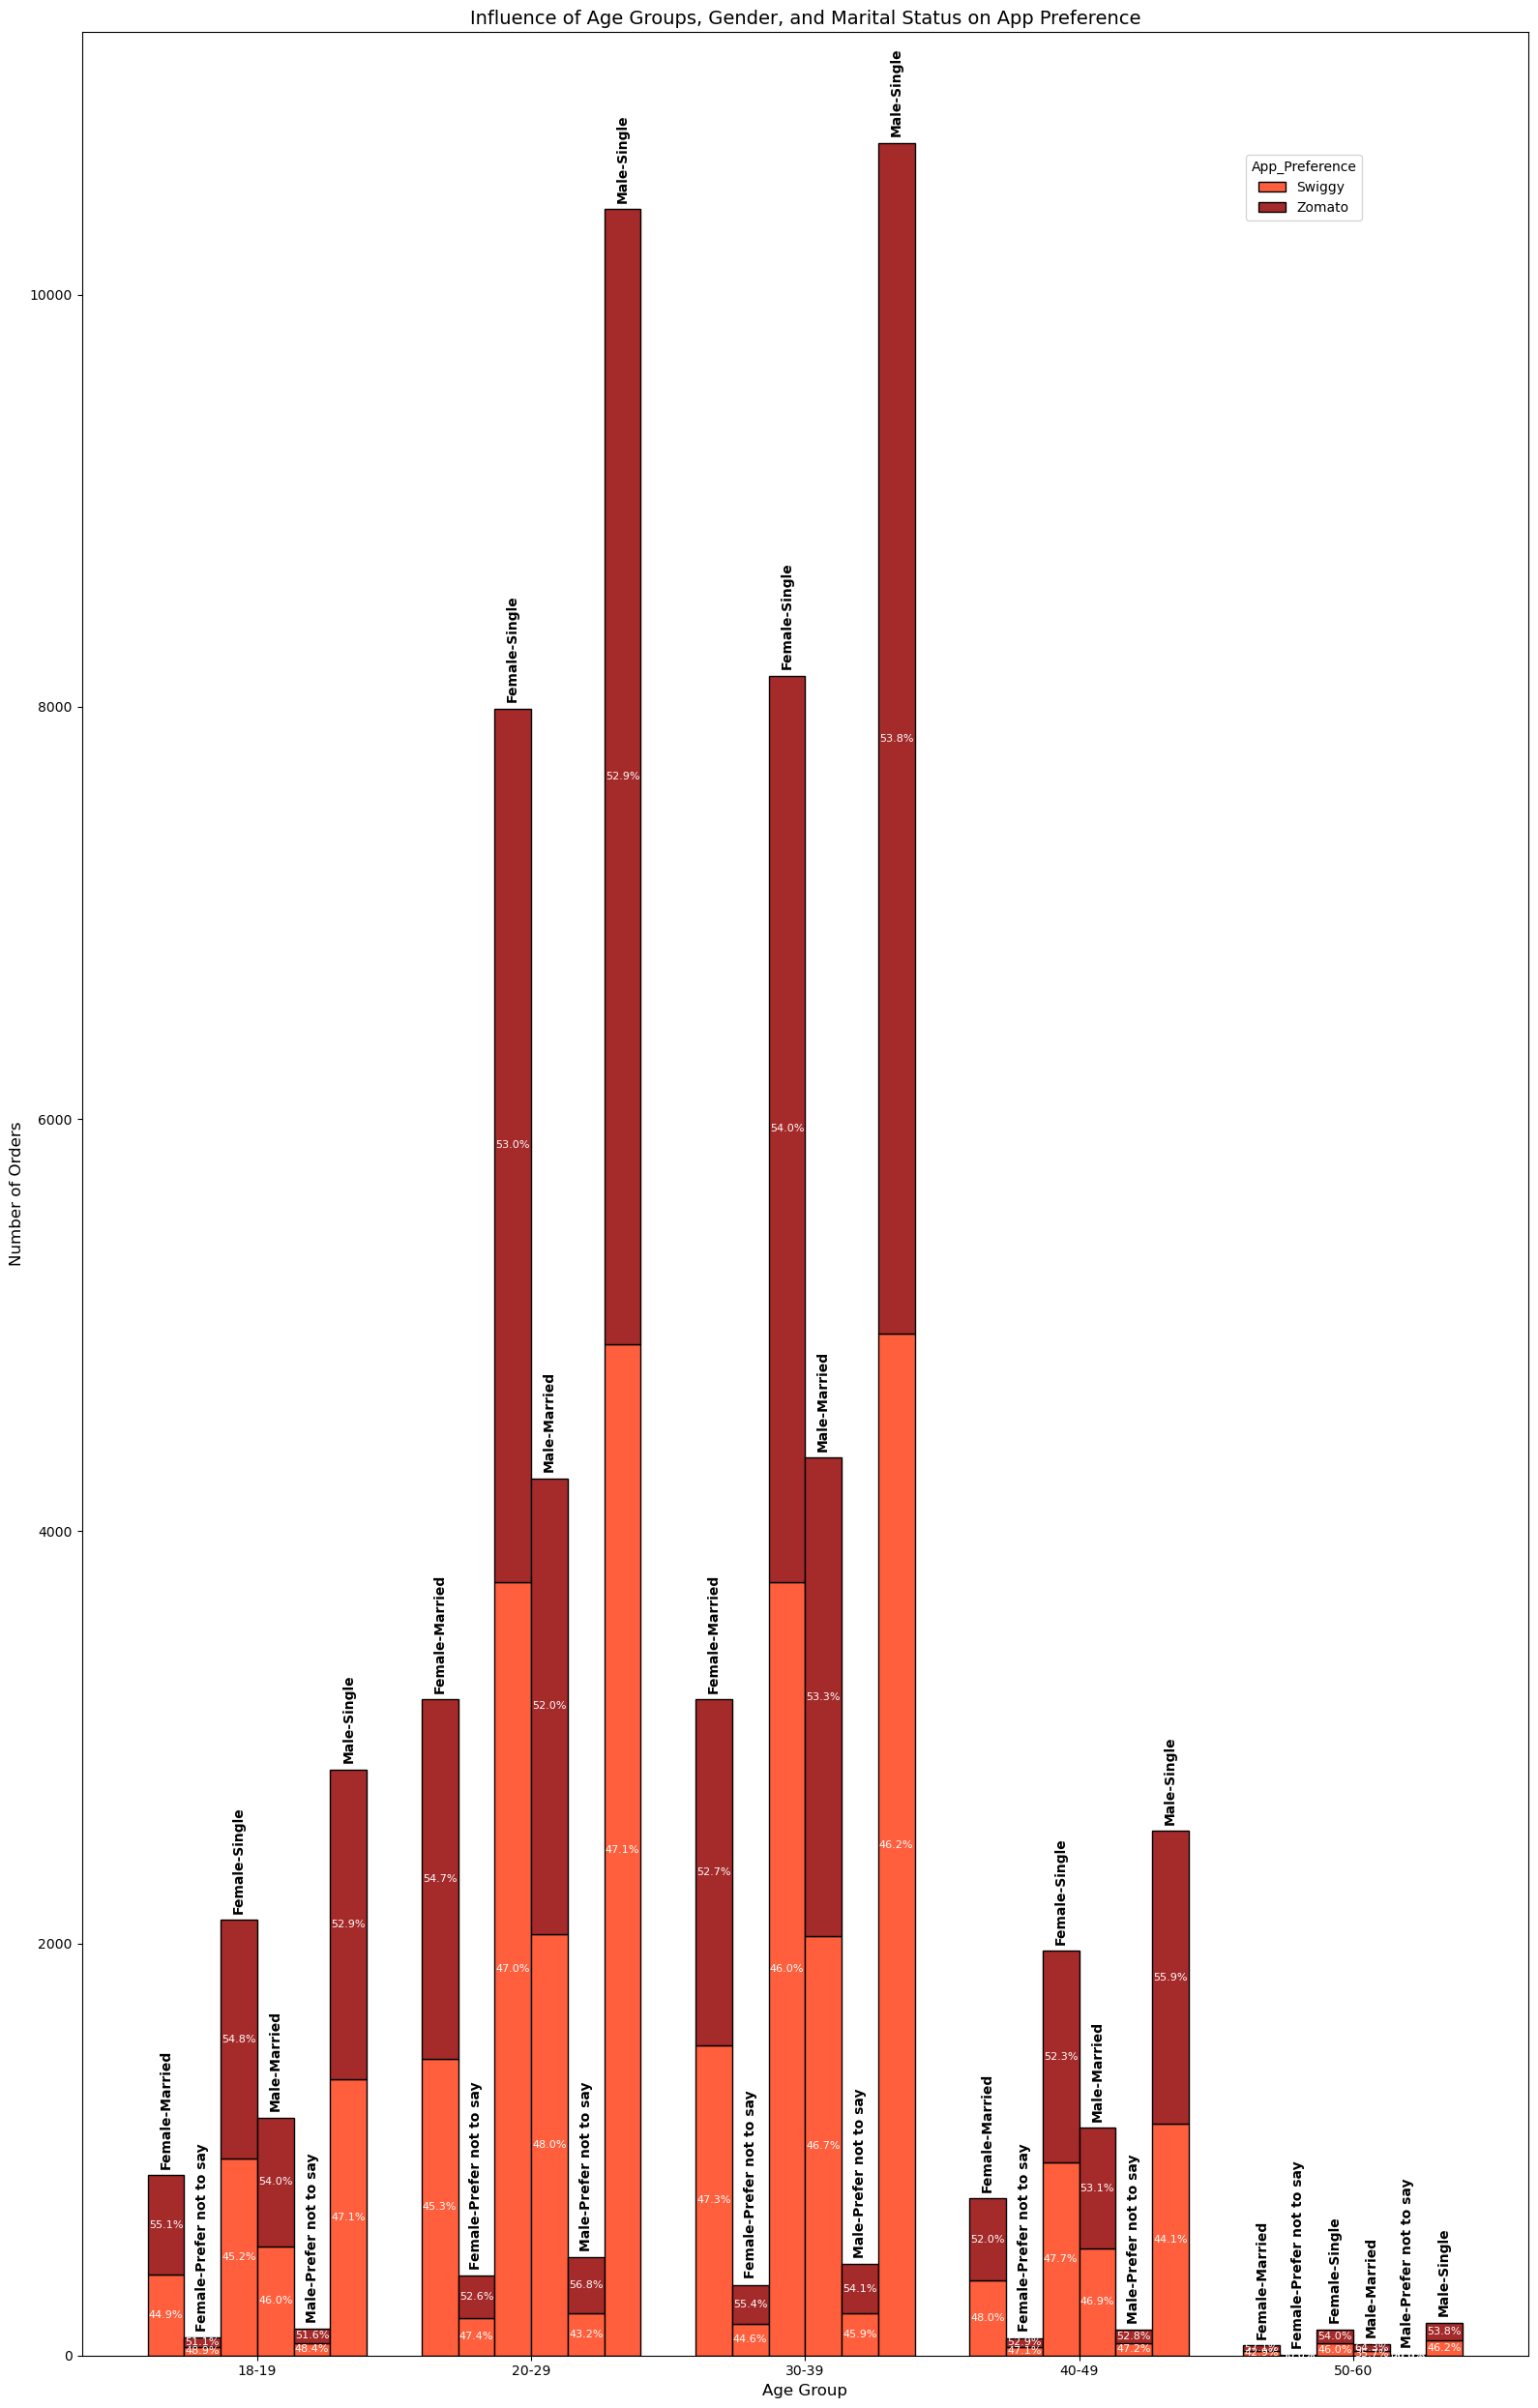

Result fetched successfully...


/var/folders/cy/g384q62d2zsbh3mc3hcvn4dr0000gn/T/ipykernel_3437/1915097940.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detailed_data['Age_Group'] = pd.cut(detailed_data['Age'], bins=[0, 25, 40, 60], labels=['<25', '25-40', '40-60'])
/var/folders/cy/g384q62d2zsbh3mc3hcvn4dr0000gn/T/ipykernel_3437/1915097940.py:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered_grouped_data_no_area = filtered_data.groupby(
/var/folders/cy/g384q62d2zsbh3mc3hcvn4dr0000gn/T/ipykernel_3437/1915097940.py:95: FutureWarning: The default value of observed=False is dep

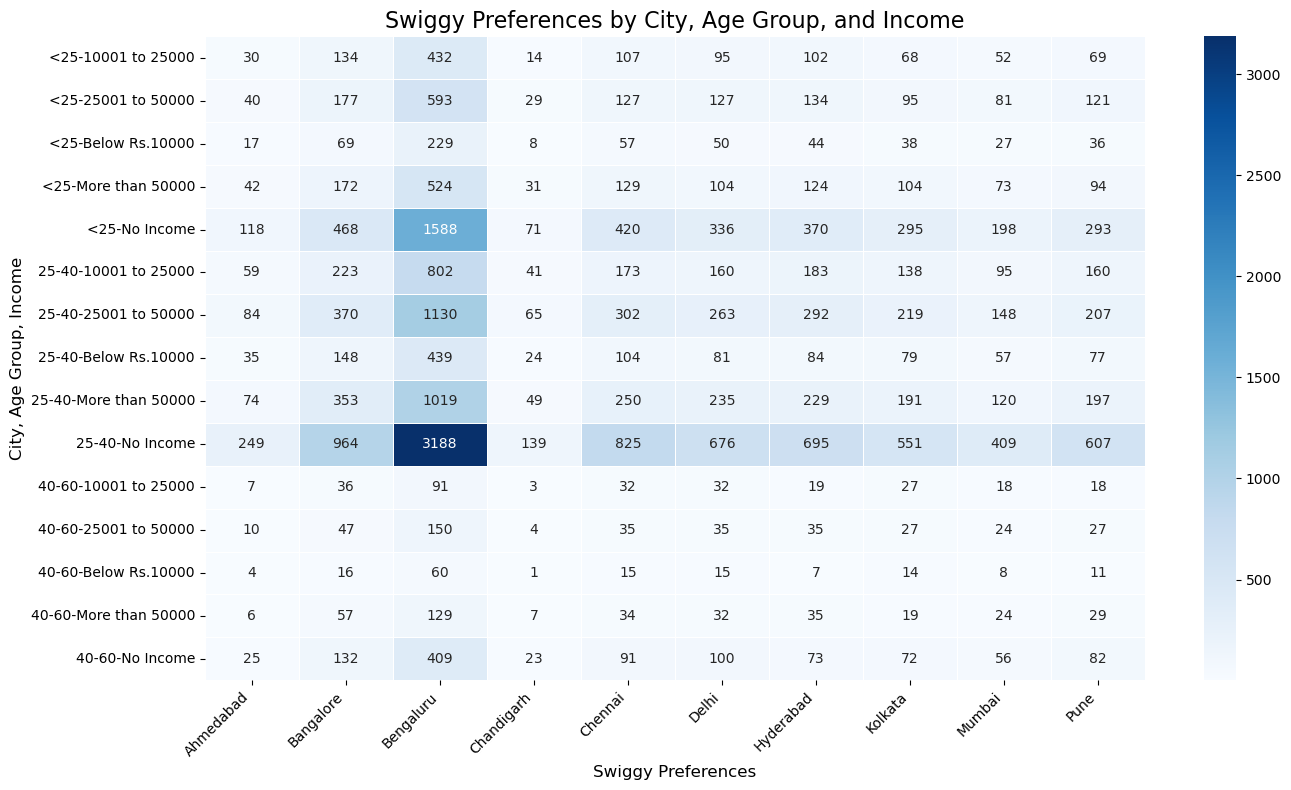

<Figure size 1400x50 with 0 Axes>

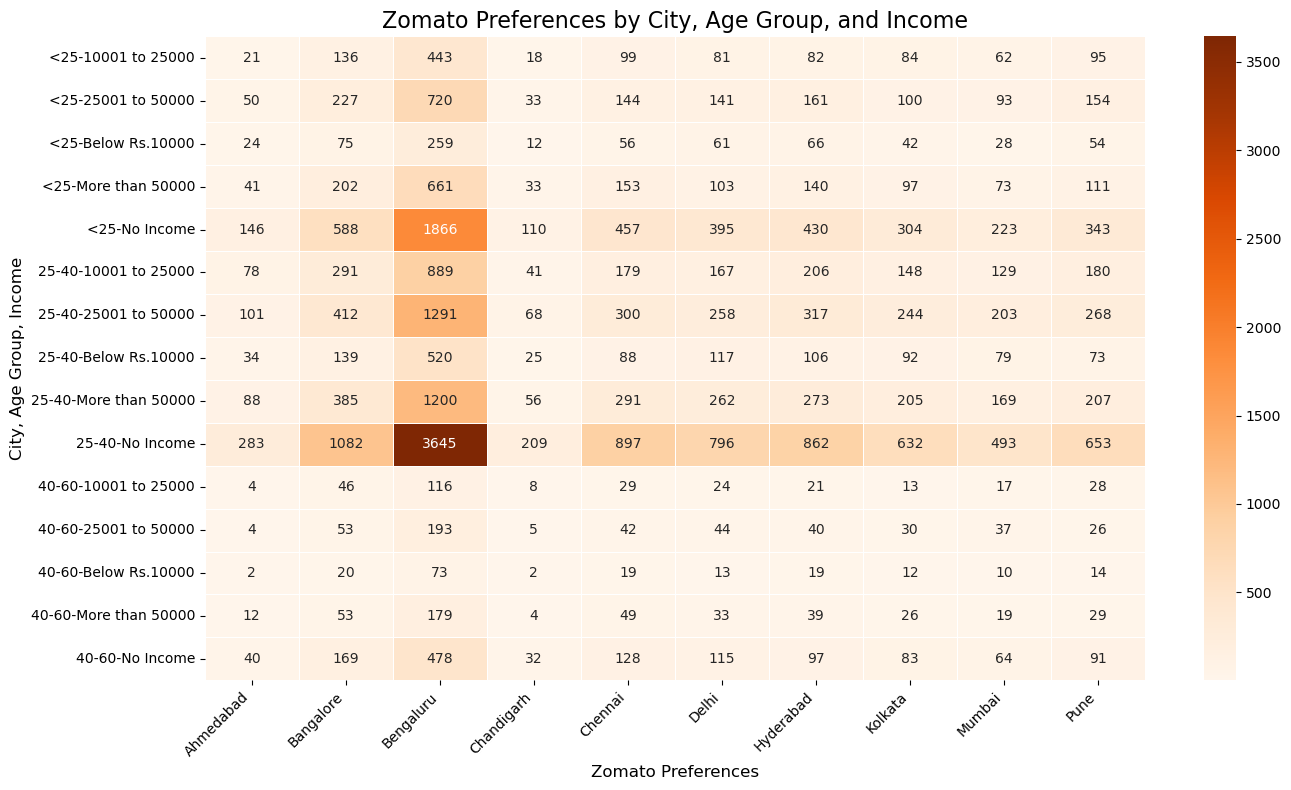

Result fetched successfully...


/var/folders/cy/g384q62d2zsbh3mc3hcvn4dr0000gn/T/ipykernel_3437/32057963.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(2, 'Total_Order_Value'))
/var/folders/cy/g384q62d2zsbh3mc3hcvn4dr0000gn/T/ipykernel_3437/32057963.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(2, 'Total_Order_Value'))


<Figure size 1400x50 with 0 Axes>

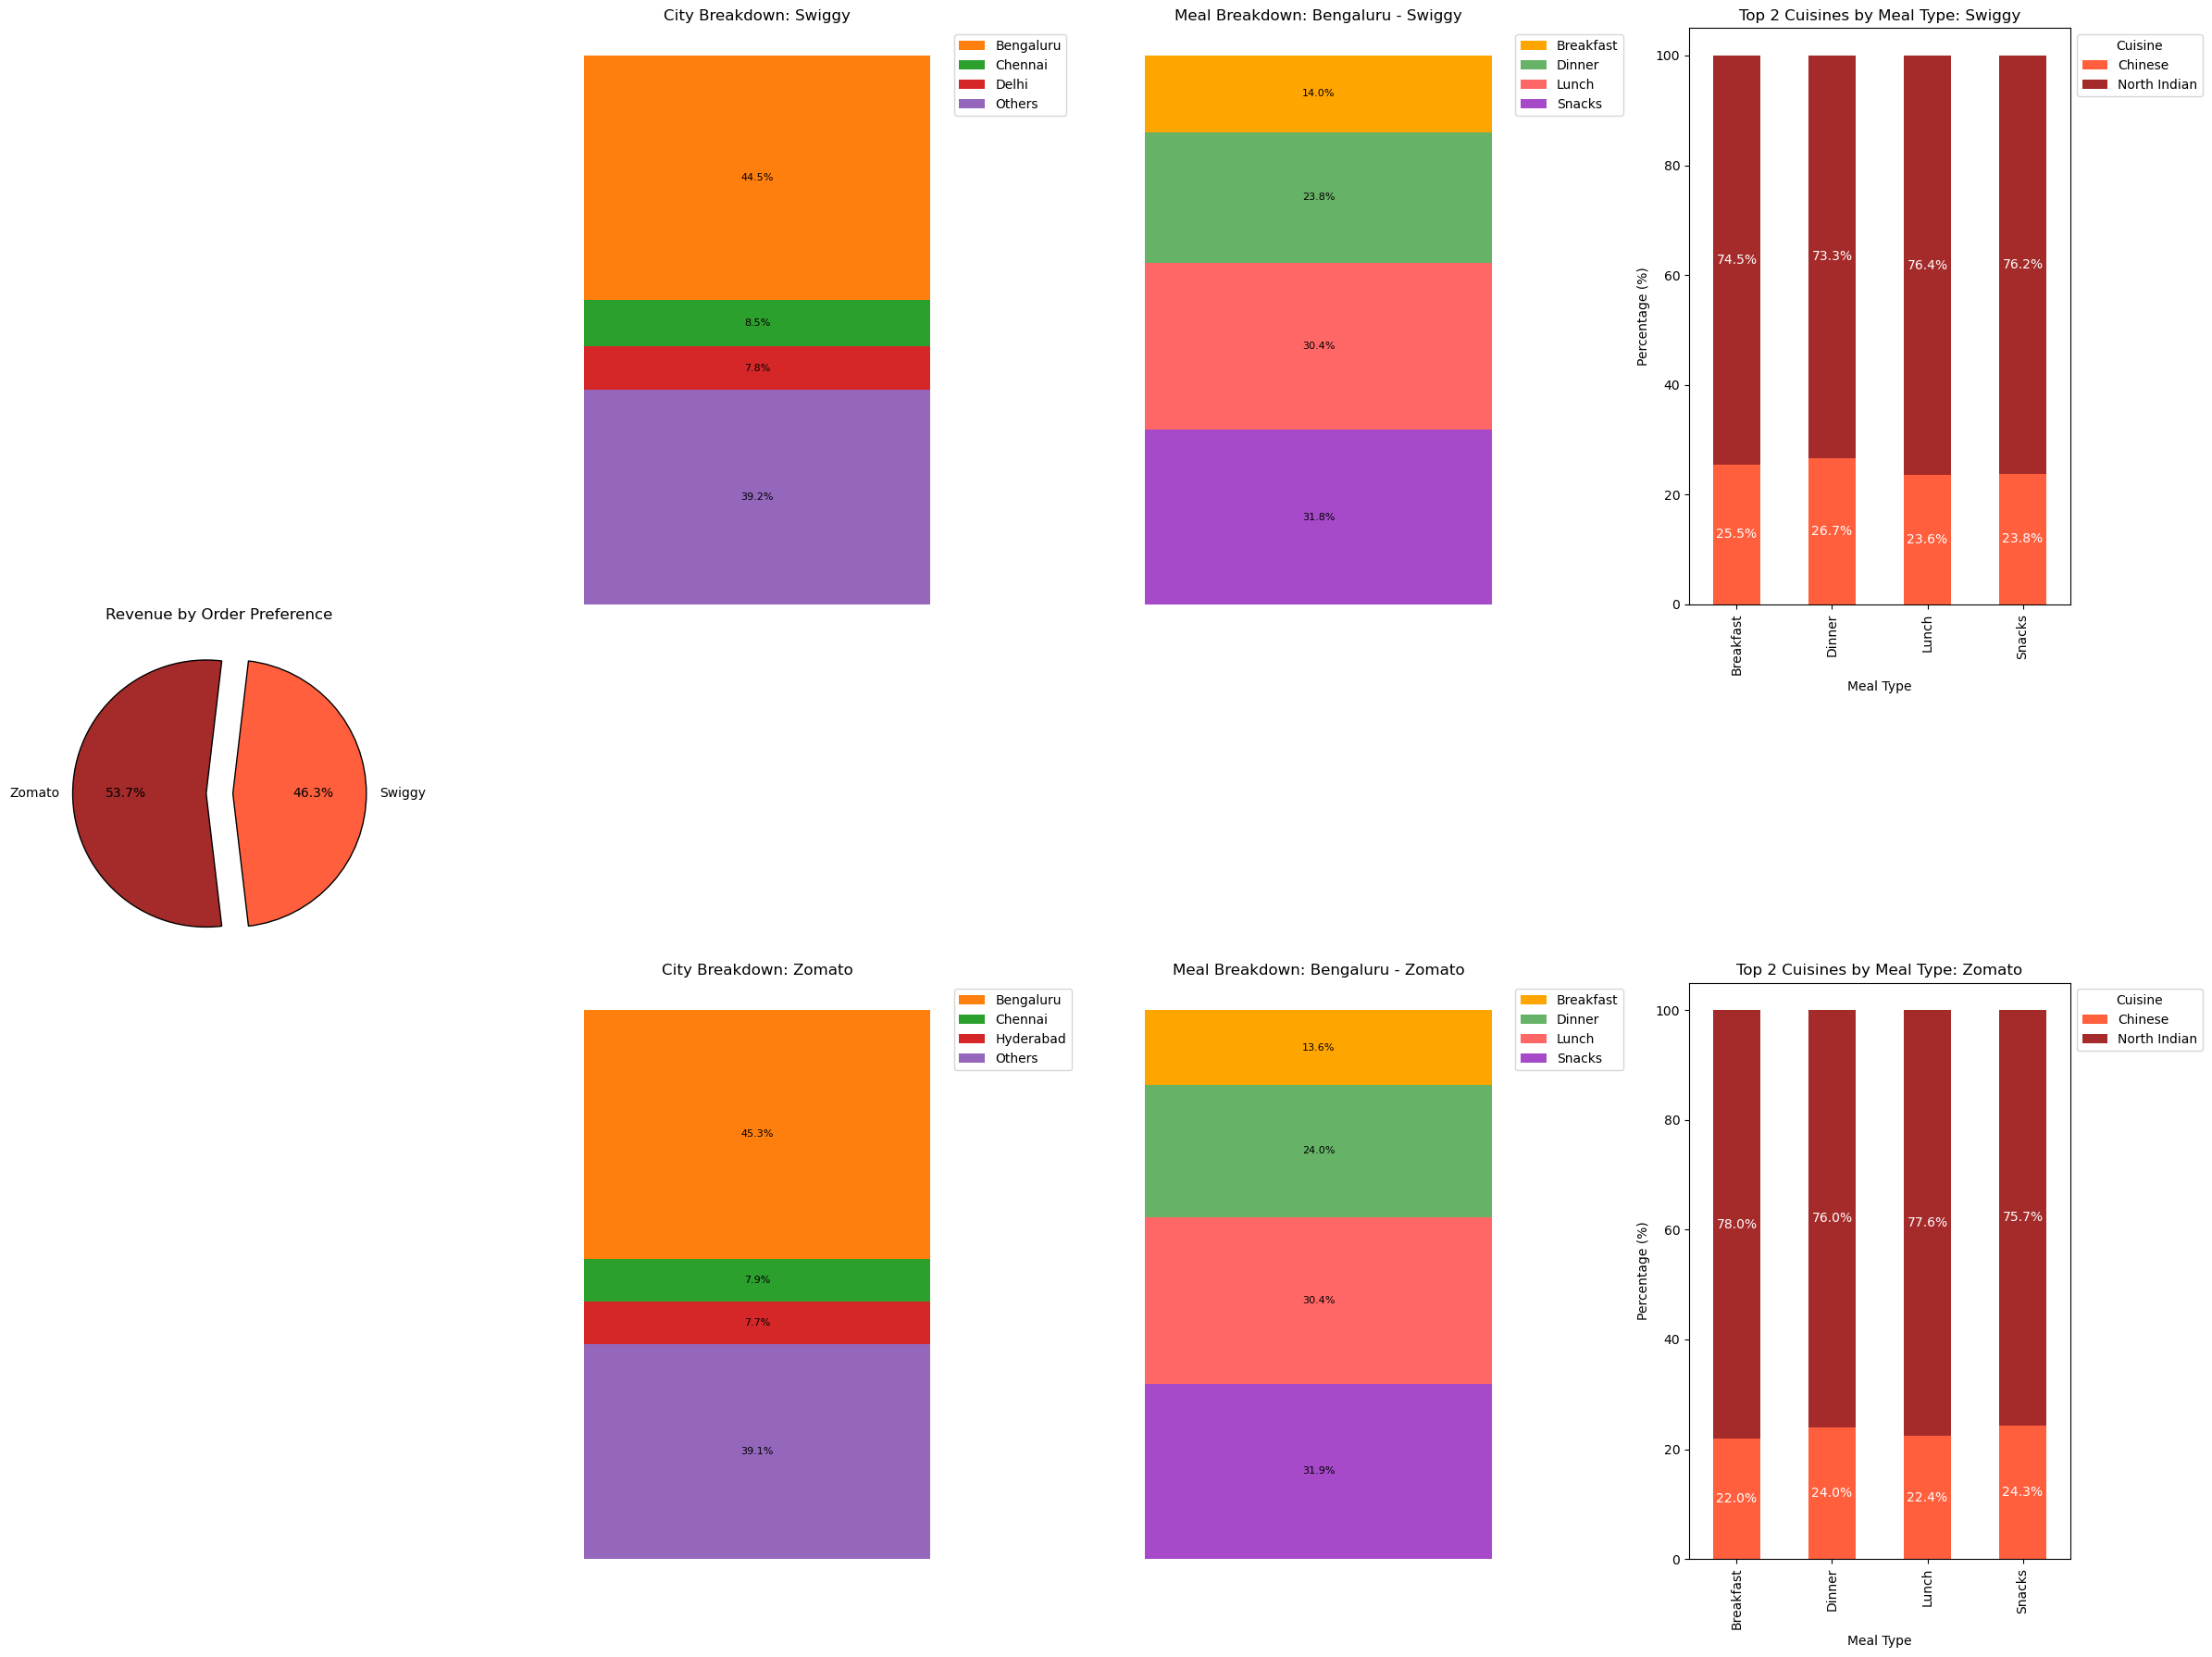

Woohoo!!! Program executed successfully.


In [679]:
# configuring custom notebook settings
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',50)
pd.set_option('display.width',1000)
__main__()